# Parameter estimation using non-linear semi-quantitative data

In this notebook we illustrate how to use non-linear semi-quantitatiave data for parameter optimization in pyPESTO. An example model is provided in `pypesto/doc/example/example_censored`.

Some measurement techniques do not ensure a linear relationship between the abundance of the biochemical quantities of interest and the measured output . Well-known examples include fluorescence microscopy data like F ̈orster resonance energy transfer (FRET) data (Birtwistle et al. [2011]), optical density (OD) measurement (Stevenson et al. [2016]) and imaging data for certain stainings (Pargett et al. [2014]).

Assuming a Gaussian distributed additive noise model, a non-linear semi-quantitative type observable has the following relationship between the biochemical quantities of intereset $(y_k = h(x(t_k, \theta), \theta))_{k=1}^{n_t}$ and the measured quantities $(\widetilde{z}_k)_{k=1}^N$
$$\widetilde{z}_k = g(y_k) + \varepsilon_k, \quad k = 1, ..., N$$
Where:

- $\{y_k\}_{k=1}^N$ is the model output at timepoints $\{t_k\}_{k=1}^N$, 
- $\{\varepsilon_k\}_{k=1}^N$ is the normally distributed measurement noise, 
- and $\theta$ is the vector of model (unknown) mechanistic model parameters.

In pyPESTO, we have implemented an alogorithm which constructs and optimizes a spline approximation $s(y, \xi)$ (to be exact, a piecewise linear function) of the non-linear monotone function $g(y_k)$. 

Using this spline appoximation of the function $g$ we can then obtain spline-mapped simulations $\{z_k = s(y_k, \xi)\}_{k=1}^N$ that are comparable to the measured quantities. Thus, we can define a negative log-likelihood objective function and optimize it to obtain maximum likelihood estimates. For better efficiency, the objective function is optimized hierarchically

- The dynamical parameters $\theta$ are optimized in the outer hierarchical loop,
- The spline parameters $\xi$ are optimized in the inner loop for each iteration of the outer one.

In the following we will demonstrate how to use the spline approximation approach for integration of nonlinear-monotone data.

## Problem specification & importing model from the petab_problem

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import petab

import pypesto
import pypesto.logging
import pypesto.optimize as optimize
import pypesto.petab
from pypesto.C import LIN, InnerParameterType
from pypesto.hierarchical.spline_approximation import (
    SplineInnerProblem,
    SplineInnerSolver,
)
from pypesto.hierarchical.spline_approximation.parameter import (
    SplineInnerParameter,
)
from pypesto.visualize import (
    plot_splines_from_inner_result,
    plot_splines_from_pypesto_result,
)
from pypesto.visualize.model_fit import visualize_optimized_model_fit

As the spline approach is implemented in the hierarchical manner, it requires us to specify `hierarchical=True` to the petab importer:

In [3]:
petab_folder = './example_nonlinear_monotone/'
yaml_file = 'example_nonlinear_monotone.yaml'

petab_problem = petab.Problem.from_yaml(petab_folder + yaml_file)

importer = pypesto.petab.PetabImporter(petab_problem, hierarchical=True)

Visualization table not available. Skipping.


The only difference in the PEtab formulation is in the `measurementType` column of the measurement file. The non-linear (monotone) semi-quantitative measurements have to be specified file by adding  `nonlinear_monotone` in this column.

In [4]:
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(petab_problem.measurement_df)

,observableId,preequilibrationConditionId,simulationConditionId,measurement,time,observableParameters,noiseParameters,observableTransformation,noiseDistribution,measurementType
0,Activity,NaN,Inhibitor_0,7.682403,5,NaN,1,lin,normal,nonlinear_monotone
1,Activity,NaN,Inhibitor_3,7.876107,5,NaN,1,lin,normal,nonlinear_monotone
2,Activity,NaN,Inhibitor_10,8.314587,5,NaN,1,lin,normal,nonlinear_monotone
3,Activity,NaN,Inhibitor_25,9.130915,5,NaN,1,lin,normal,nonlinear_monotone
4,Activity,NaN,Inhibitor_35,8.078494,5,NaN,1,lin,normal,nonlinear_monotone
5,Activity,NaN,Inhibitor_50,5.452116,5,NaN,1,lin,normal,nonlinear_monotone
6,Activity,NaN,Inhibitor_75,2.698746,5,NaN,1,lin,normal,nonlinear_monotone
7,Activity,NaN,Inhibitor_100,1.673154,5,NaN,1,lin,normal,nonlinear_monotone
8,Activity,NaN,Inhibitor_300,0.392886,5,NaN,1,lin,normal,nonlinear_monotone
9,Ybar,NaN,Inhibitor_0,0.000000,5,NaN,1,lin,normal,nonlinear_monotone


To estimate the noise parameters of the nonlinear-monotone observables, those noise parameters in the `parameter.tsv` file have to have column entries `estimate` with value 1 and column entry `parameterType` with value `sigma`, as in case of using relative (scaling+offset) data:

In [5]:
import pandas as pd

noise_parameter_file = 'parameters_example_nonlinear_monotone_noise.tsv'
# load the csv file
noise_parameter_df = pd.read_csv(petab_folder + noise_parameter_file, sep='\t')
with option_context('display.max_colwidth', 400):
    display(noise_parameter_df)

,parameterId,parameterName,parameterScale,lowerBound,upperBound,nominalValue,estimate,parameterType
0,K1,K1,lin,-5.00000,5.0,0.04,0,NaN
1,K2,K2,lin,-5.00000,5.0,20.00,0,NaN
2,K3,K3,log10,0.10000,100000.0,4000.00,1,NaN
3,K5,K5,log10,0.00001,100000.0,0.10,1,NaN
4,sd_Activity,\sigma_{activity},lin,0.00000,inf,1.00,1,sigma
5,sd_Ybar,\sigma_{ybar},lin,0.00000,inf,1.00,1,sigma


#### Note on inclusion of additional data types:
It is possible to include observables with different types of data to the same `petab_problem`. Refer to the notebooks on using [ordinal data](ordinal.ipynb) and [censored data](censored.ipynb) for details on integration of other data types. If the `measurementType` column is left empty for all measurements of an observable, the observable will be treated as quantitative.

## Constructing the objective and pypesto problem

The spline approximation options that can be specified are the following

- `spline_ratio`: float value, determines the number of spline knots as `n_spline_pars` = `spline_ratio` * `n_datapoints`  
- `min_diff_factor` : float value, determines the minimal difference between consecutive spline heights as `min_diff_factor` * `measurement_range` / `n_spline_pars`. Set it to 0.0 to disable.
- `regularize_spline`: boolean value, determines whether the spline is regularized by a linear function. In most cases, this this option improves method convergence. The goal is to reduce false positive data non-linear splines by pushing them towards a linear line.
- `regularization_factor`: float value, determines the strength of the regularization. It is the $\lambda$ factor in the objective function $J(\theta, \xi) = -\log \mathcal{L}_{\mathcal{D}}(\theta, \xi) + \lambda R(\xi)$, where $-\log \mathcal{L}_{\mathcal{D}}(\theta, \xi)$ is the negative log-likelihood and $R(\xi)$ is the regularization.

The `min_diff_factor` is a multiplier of the minimal difference between spline heights. Positive values act as a penalty in the objective function for incorrect orderings; this penalty can improve convergence for most models. However, high `min_diff_factor` values will reduce the spline's ability to approximate functions with flat regions accurately. This issue will be demonstrated in the last section.

Now when we construct the `objective`, it will construct all objects of the optimal scaling inner optimization:

- `SplineInnerSolver`
- `SplineAmiciCalculator`
- `SplineInnerProblem`

Specifically, the `SplineInnerSolver` and `SplineInnerProblem` will be constructed with default settings of 

- `spline_ratio` = 1/2
- `use_minimal_difference` = 0.0
- `regularize_spline` = False
- `regularization_factor` = 0.0

In [6]:
objective = importer.create_objective()

amici model will be re-imported due to version mismatch: Cannot use model `Raf_Mitra_NatCom2018OptimalScaling_3CatQual` in /Users/zebo/Documents/PhD/Projects/pypesto_amici_dev/dev_venv/pyPESTO/doc/example/amici_models/Raf_Mitra_NatCom2018OptimalScaling_3CatQual/Raf_Mitra_NatCom2018OptimalScaling_3CatQual, generated with amici==0.15.0, together with amici==0.18.1 which is currently installed. To use this model, install amici==0.15.0 or re-import the model with the amici version currently installed.
Compiling amici model to folder /Users/zebo/Documents/PhD/Projects/pypesto_amici_dev/dev_venv/pyPESTO/doc/example/amici_models/Raf_Mitra_NatCom2018OptimalScaling_3CatQual.
2023-11-30 13:29:31.502 - amici.petab_import - INFO - Importing model ...
2023-11-30 13:29:31.504 - amici.petab_import - INFO - Validating PEtab problem ...
Visualization table not available. Skipping.
2023-11-30 13:29:31.515 - amici.petab_import - INFO - Model name is 'Raf_Mitra_NatCom2018OptimalScaling_3CatQual'.
Writing 

running AmiciInstall
running build_ext
running AmiciBuildCMakeExtension
------------------------------ model_ext ------------------------------

==> Configuring:
$ cmake -S /Users/zebo/Documents/PhD/Projects/pypesto_amici_dev/dev_venv/pyPESTO/doc/example/amici_models/Raf_Mitra_NatCom2018OptimalScaling_3CatQual -B /Users/zebo/Documents/PhD/Projects/pypesto_amici_dev/dev_venv/pyPESTO/doc/example/amici_models/Raf_Mitra_NatCom2018OptimalScaling_3CatQual/build_model_ext -GNinja -DCMAKE_BUILD_TYPE=Release -DCMAKE_INSTALL_PREFIX:PATH=/Users/zebo/Documents/PhD/Projects/pypesto_amici_dev/dev_venv/pyPESTO/doc/example/amici_models/Raf_Mitra_NatCom2018OptimalScaling_3CatQual/Raf_Mitra_NatCom2018OptimalScaling_3CatQual -DCMAKE_MAKE_PROGRAM=/Users/zebo/Documents/PhD/Projects/pypesto_amici_dev/dev_venv/bin/ninja -DCMAKE_VERBOSE_MAKEFILE=ON -DCMAKE_MODULE_PATH=/Users/zebo/Documents/PhD/Projects/pypesto_amici_dev/dev_venv/lib/python3.10/site-packages/amici/lib/cmake/SuiteSparse;/Users/zebo/Documents/Ph

2023-11-30 13:29:48.903 - amici.petab_import - INFO - Finished Importing PEtab model                 (1.74E+01s)
2023-11-30 13:29:48.906 - amici.petab_import - INFO - Successfully loaded model Raf_Mitra_NatCom2018OptimalScaling_3CatQual from /Users/zebo/Documents/PhD/Projects/pypesto_amici_dev/dev_venv/pyPESTO/doc/example/amici_models/Raf_Mitra_NatCom2018OptimalScaling_3CatQual.


To give non-default options to the `OptimalScalingInnerSolver` and `OptimalScalingProblem`, one can pass them as arguments when constructing the `objective`:

In [8]:
objective = importer.create_objective(
    inner_options={
        "spline_ratio": 1 / 2,
        "min_diff_factor": 1 / 2,
        "regularize_spline": True,
        "regularization_factor": 1e-1,
    },
)

Alternatively, one can even pass them to the importer constructor `pypesto.petab.PetabImporter()`.

If changing the `spline_ratio` setting, one has to re-construct the objective object, as this requires a constuction of the new `SplineInnerProblem` object with the requested amount of inner parameters.

Now let's construct the pyPESTO problem and optimizer. We're going to use a gradient-based optimizer for a faster optimization, but gradient-free optimizers can be used in the same way:

In [9]:
problem = importer.create_problem(objective)

engine = pypesto.engine.SingleCoreEngine()

optimizer = optimize.ScipyOptimizer(
    method="L-BFGS-B",
    options={"disp": None, "ftol": 2.220446049250313e-09, "gtol": 1e-5},
)
n_starts = 10

## Running optimization using spline approximation

Now running optimization is as simple as running usual pyPESTO miminization:

In [10]:
np.random.seed(n_starts)

result = optimize.minimize(
    problem, n_starts=n_starts, optimizer=optimizer, engine=engine
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


The model optimization has good convergence with a plateu at the optimal point:

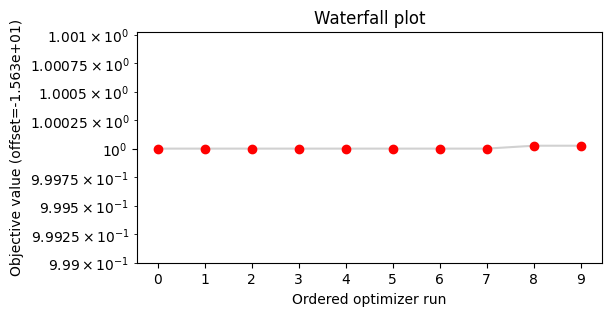

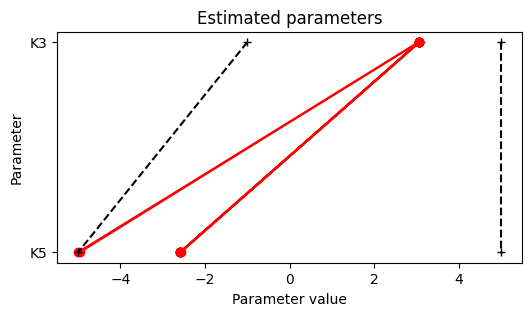

In [20]:
from pypesto.visualize import parameters, waterfall

waterfall([result], size=(6, 3))
plt.show()
parameters([result], size=(6, 3))
plt.show()

We can plot the optimized spline of the best start using the `plot_from_pypesto_result` visualization:

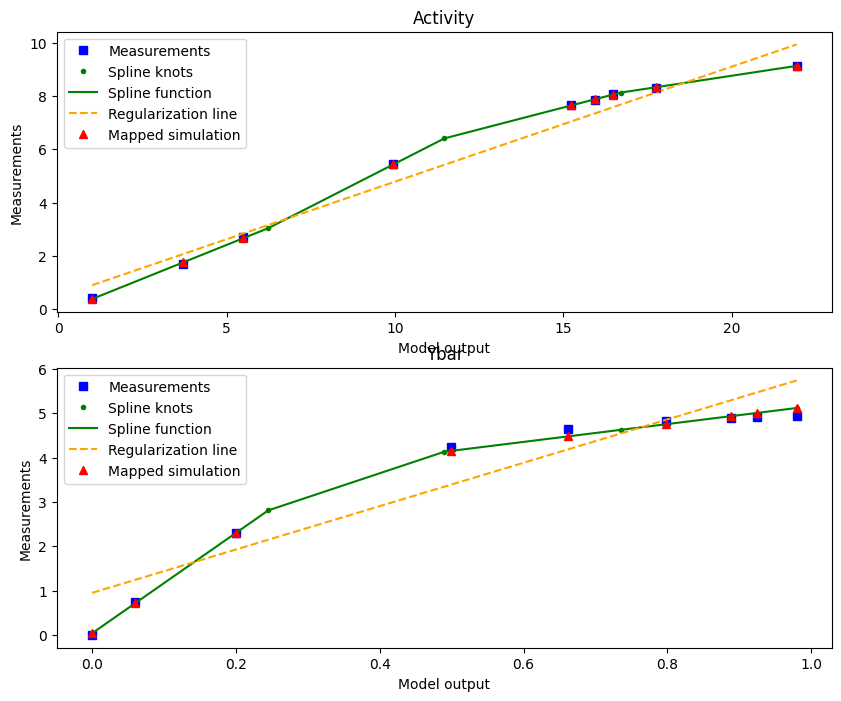

In [19]:
plot_splines_from_pypesto_result(result, figsize=(10, 8))
plt.show()

We can also plot the model fit (observable trajectories) with the spline-mapped simulations included using `visualize_optimized_model_fit`.

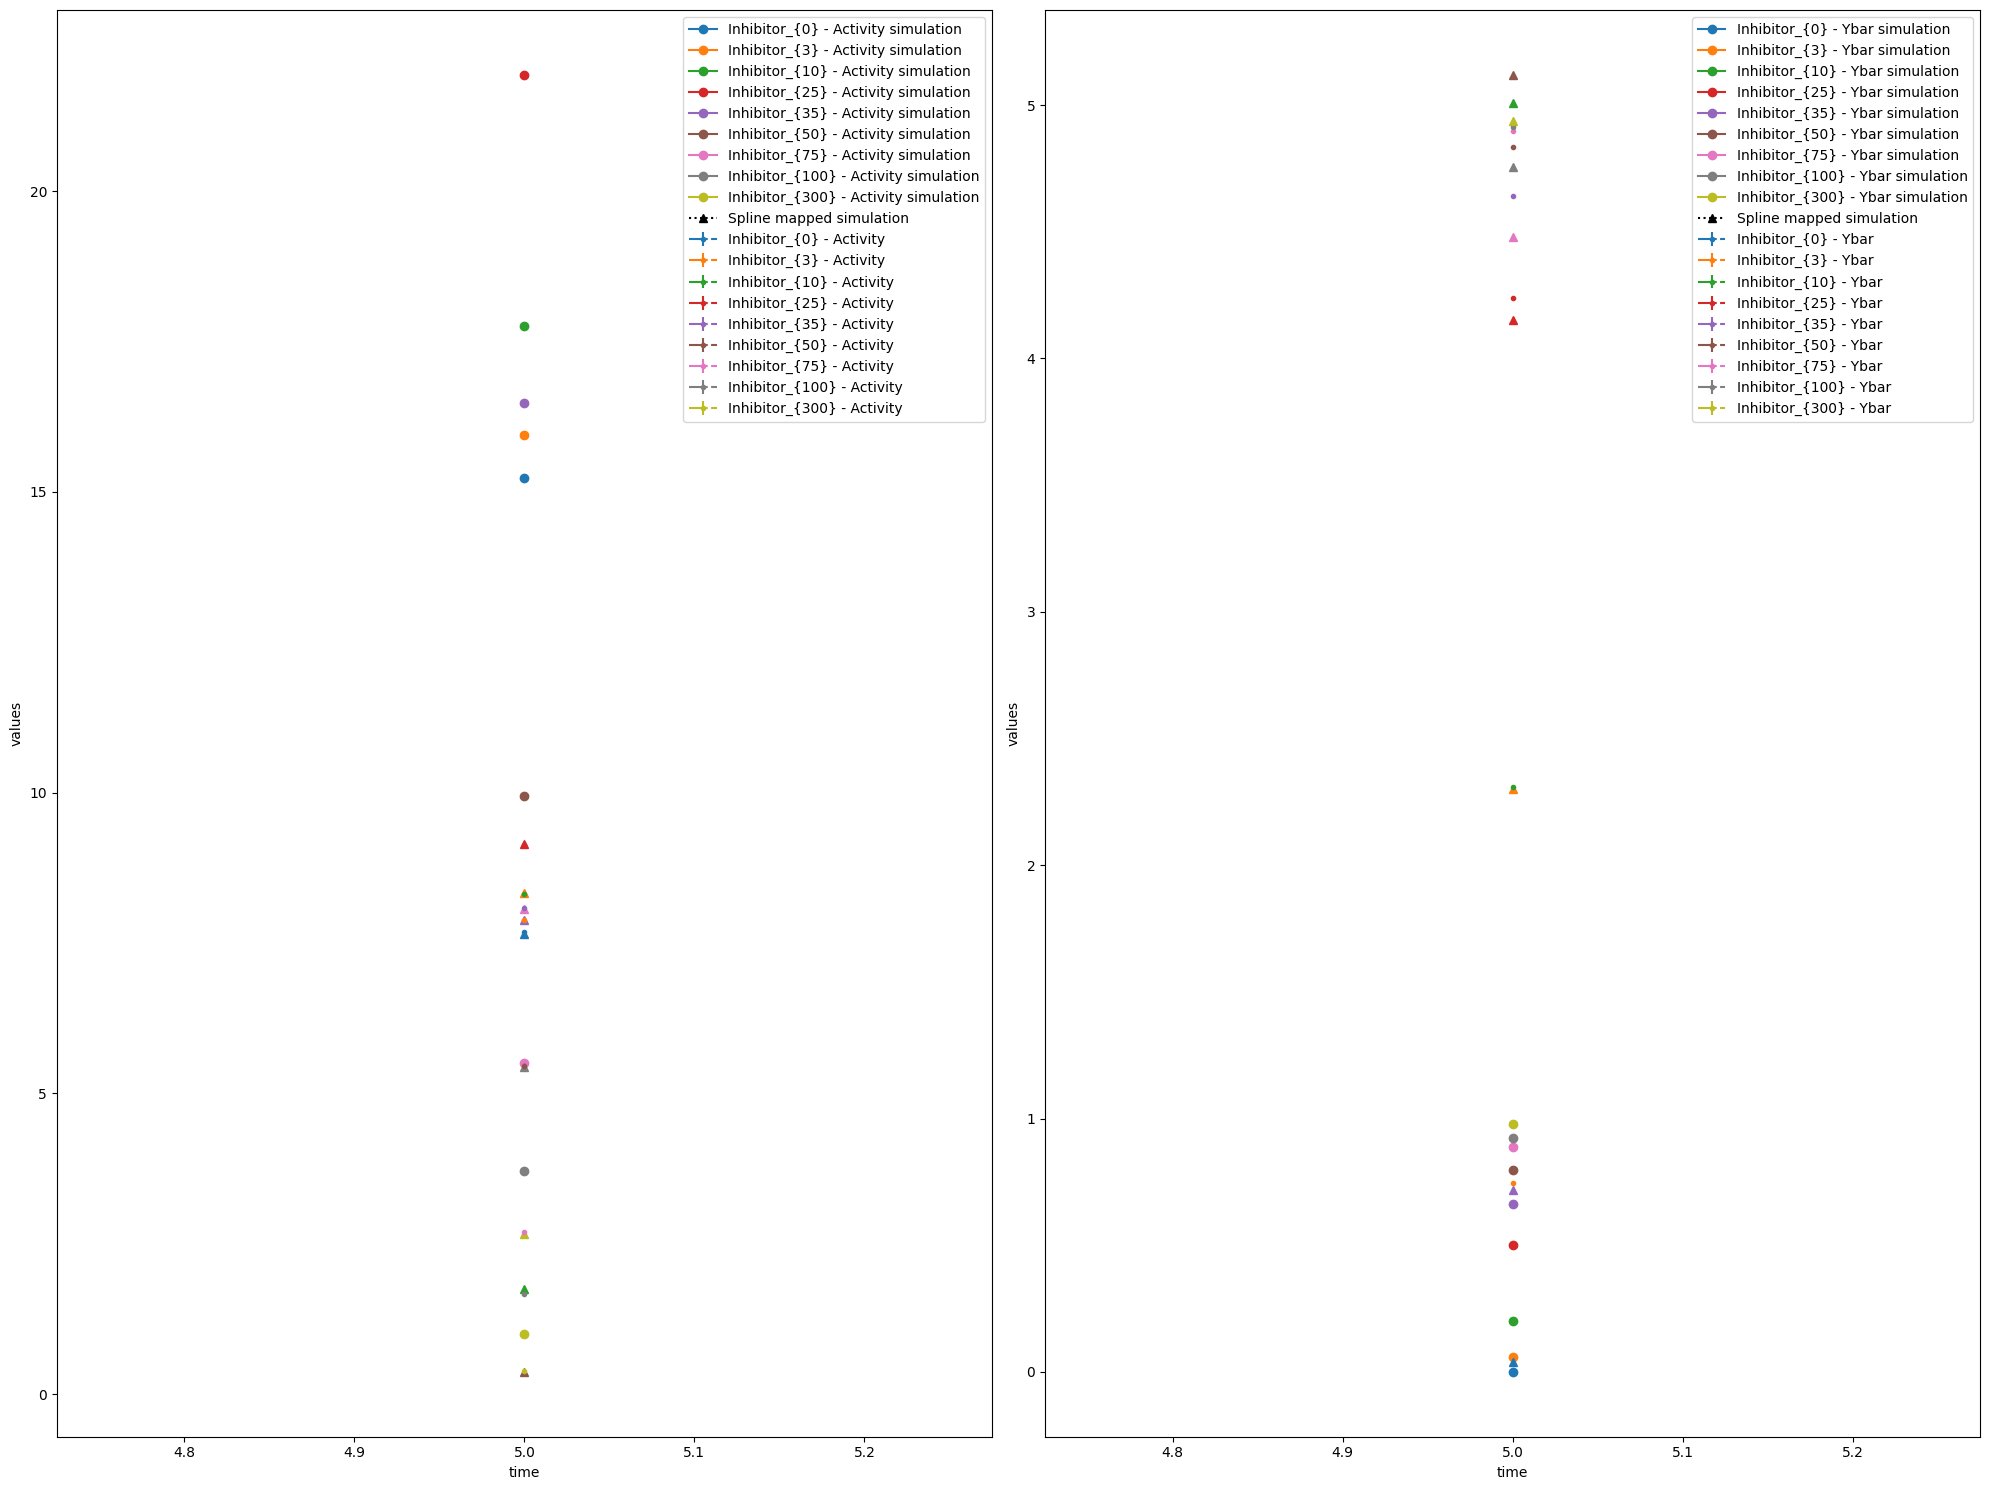

In [13]:
visualize_optimized_model_fit(
    petab_problem,
    result,
    problem,
)
plt.show()

## Caution when using minimal difference

To illustrate that minimal difference sometimes has a negative effect we will apply it to a very simple synthetic "model" -- simulation of the exponential function:

Using minimal_diff_on options: {'min_diff_factor': 0.5}


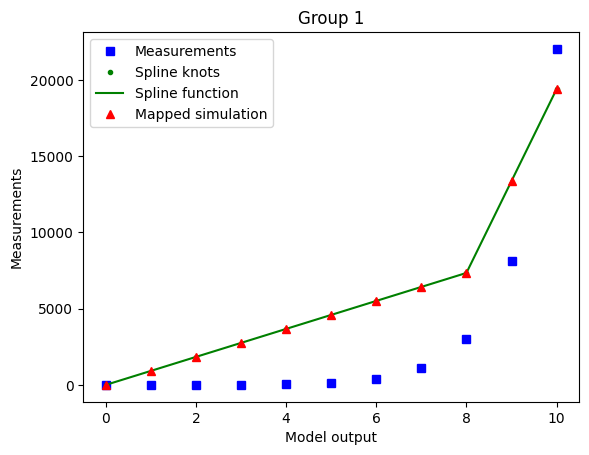

Using minimal_diff_off options: {'min_diff_factor': 0.0}


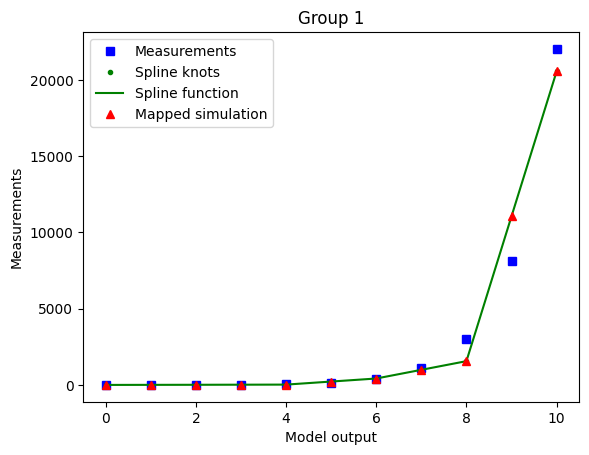

In [17]:
timepoints = np.linspace(0, 10, 11)
function = np.exp

simulation = timepoints
sigma = np.full(len(timepoints), 1)

# Create synthetic data as the exponential function of timepoints
data = function(timepoints)

spline_ratio = 1 / 2
n_spline_pars = int(np.ceil(spline_ratio * len(timepoints)))


par_type = 'spline'
mask = [np.full(len(simulation), True)]

inner_parameters = [
    SplineInnerParameter(
        inner_parameter_id=f'{par_type}_{1}_{par_index+1}',
        inner_parameter_type=InnerParameterType.SPLINE,
        scale=LIN,
        lb=-np.inf,
        ub=np.inf,
        ixs=mask,
        index=par_index + 1,
        group=1,
        observable_id='observable_1',
    )
    for par_index in range(n_spline_pars)
]

inner_problem = SplineInnerProblem(
    xs=inner_parameters, data=[data], spline_ratio=spline_ratio
)

options = {
    'minimal_diff_on': {
        'min_diff_factor': 1 / 2,
    },
    'minimal_diff_off': {
        'min_diff_factor': 0.0,
    },
}
inner_solvers = {}
results = {}

for minimal_diff, option in options.items():
    inner_solvers[minimal_diff] = SplineInnerSolver(
        options=option,
    )
    print(f'Using {minimal_diff} options: {option}')

    # Solve the inner problem to obtain the optimal spline
    results[minimal_diff] = inner_solvers[minimal_diff].solve(
        problem=inner_problem,
        sim=[simulation],
        amici_sigma=[sigma],
    )

    plot_splines_from_inner_result(
        inner_problem, inner_solvers[minimal_diff], results[minimal_diff]
    )
    plt.show()

The optimized spline for the case with enabled minimal difference is performing much worse even if we use a non-extreme `min_diff_factor` value. This is due to the relative flatness of the data with respect to the true model output.

The minimal difference is determined as 
$$\text{min diff} = \text{min diff factor} \cdot \frac{\text{measurement range}}{\text{n inner pars}}$$ 
so for nonlinear-monotone functions which are relatively flat on some intervals, it is best to keep the minimal difference disabled.

As the true output (e.g. observable simulation of the model with true parameters) is mostly a-priori not known, it's hard to know whether the minimal difference is going to have a bad or good effect on the optimization. So a good heuristic is to run for different values of `min_diff_factor` and compare results.